### Basic Tutorial: Jax Version


The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

In [1]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch
import pickle
from pathlib import Path

wandb not available
wandb not available


In [2]:
# MAKE CONFIGS
RUN_SIMS = True
DEVICE = "cpu"

# Define a model
MODEL = "ddm" #list(ssms.config.model_config.keys())[np.random.randint(0, len(ssms.config.model_config.keys()))]
OUT_FOLDER = Path("jax_nb_data") / "lan_mlp" / "training_data"
MODEL_FOLDER = Path("jax_nb_data") / "jax_models" / "lan"
N_DATA_FILES = 2
os.makedirs(OUT_FOLDER, exist_ok=True)

# Initialize the generator config (for MLP LANs)

# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 1000
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
# Specify folder in which to save generated data
generator_config["output_folder"] = OUT_FOLDER
generator_config['n_training_samples_by_parameter_set'] = 2000

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [3]:
# MAKE DATA
if RUN_SIMS:
    for i in range(N_DATA_FILES):
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
            generator_config=generator_config, model_config=model_config
        )
        _ = my_dataset_generator.generate_data_training_uniform(save=True)

n_cpus used:  12
checking:  jax_nb_data/lan_mlp/training_data
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  jax_nb_data/lan_mlp/training_data/training_data_e8898b3a521011f08a636ae25f443f62.pickle
n_cpus used:  12
checking:  jax_nb_data/lan_mlp/training_data
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  jax_nb_data/lan_mlp/training_data/training_data_f520086a521011f08a636ae25f443f62.pickle


In [4]:
from copy import deepcopy

# MAKE FIXTURE WITH SOMEWHAT RANDOM PROPERTIES
network_config = deepcopy(lanfactory.config.network_configs.network_config_mlp)
network_config["layer_sizes"] = [100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh", "linear"]

print("Network config: ")
print(network_config)

train_config = deepcopy(lanfactory.config.network_configs.train_config_mlp)
train_config["learning_rate"] = 0.000002

# CHECK CORNER CASES
train_config["cpu_batch_size"] = 4096
train_config["gpu_batch_size"] = 4096
train_config["n_epochs"] = 2


print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 2e-06, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [8]:
# folder_ = OUT_FOLDER
file_list_ = [os.path.join(OUT_FOLDER, file_) for file_ in os.listdir(OUT_FOLDER)]


# INDEPENDENT TESTS OF DATALOADERS
# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_training_dataloader = torch.utils.data.DataLoader(
    jax_training_dataset, shuffle=True, batch_size=None, num_workers=1, pin_memory=True
)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_validation_dataloader = torch.utils.data.DataLoader(
    jax_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

#### Define Network

In [9]:
# LOAD NETWORK
# Test properties of network
jax_net = lanfactory.trainers.MLPJaxFactory(network_config=network_config, train=True)

# Save model config
# model_folder = os.path.join("data", "jax_models", MODEL)
# os.makedirs(model_folder, exist_ok = True)

# pickle.dump(
#     network_config,
#     open(os.path.join(model_folder,
# 					  "jax_network_config.pickle"), "wb")
# 		)

#### Train 

In [10]:
# Test properties of jax trainer
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(
    train_config=train_config,
    model=jax_net,
    train_dl=jax_training_dataloader,
    valid_dl=jax_validation_dataloader,
    pin_memory=True,
)

In [14]:
# Test if training loop works
train_state = jax_trainer.train_and_evaluate(
    output_folder=MODEL_FOLDER,
    output_file_id=MODEL,
    run_id="jax",
    wandb_on=False,
    wandb_project_id="jax",
    verbose=1,
    save_outputs=True,
)

Epoch: 0 of 2


/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_lanfactory/LANfactory/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


wandb not available
wandb not available
Training - Step: 0 of 952 - Loss: 4.155462
Epoch 0/2 time: 10.643912076950073s
wandb not available
wandb not available
Validation - Step: 0 of 952 - Loss: 0.09997503
Epoch 0/2 time: 8.438811779022217s
Epoch: 0 / 2, test_loss: 0.10196932405233383
Epoch: 1 of 2
wandb not available
wandb not available
Training - Step: 0 of 952 - Loss: 0.1102554
Epoch 1/2 time: 9.941360235214233s
wandb not available
wandb not available
Validation - Step: 0 of 952 - Loss: 0.05326052
Epoch 1/2 time: 8.238975048065186s
Epoch: 1 / 2, test_loss: 0.0613735094666481
Saving training history to: jax_nb_data/jax_models/lan/jax_lan_ddm__jax_training_history.csv
Saving model parameters to: jax_nb_data/jax_models/lan/jax_lan_ddm__train_state.jax
Saving training config to: jax_nb_data/jax_models/lan/jax_lan_ddm__train_config.pickle
Saving training data details to: jax_nb_data/jax_models/lan/jax_lan_ddm__data_details.pickle


#### Check Trained Network

We can now re-instantiate our network from the trained weights and check that the output are reasonable.

In [15]:
# Loaded Net
# Test passing network config as path and as object

jax_infer = lanfactory.trainers.MLPJaxFactory(
	            network_config=network_config,
                train=False,
            )

In [17]:
# Test passing train state as path and as object
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state=os.path.join(MODEL_FOLDER,
					   "jax_lan_" + MODEL + "__train_state.jax"),
    add_jitted=True,
)

In [22]:
import jax.numpy as jnp

# Test parameters:
theta = deepcopy(ssms.config.model_config[MODEL]["default_params"])

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(
    model=MODEL, theta=theta, n_samples=50000
)

# Make input matrix
input_mat = jnp.zeros((2000, len(theta) + 2))
for i in range(len(theta)):
    input_mat = input_mat.at[:, i].set(jnp.ones(2000) * theta[i])

input_mat = input_mat.at[:, len(theta)].set(
    jnp.array(
        np.concatenate(
            [
                np.linspace(5, 0, 1000).astype(np.float32),
                np.linspace(0, 5, 1000).astype(np.float32),
            ]
        )
    )
)
input_mat = input_mat.at[:, len(theta) + 1].set(
    jnp.array(
        np.concatenate([np.repeat(-1.0, 1000), np.repeat(1.0, 1000)]).astype(np.float32)
    )
)

net_out = forward_pass_jitted(input_mat)

(array([1.20920274e-04, 1.20920274e-04, 1.20920274e-04, 1.20920274e-04,
        2.41840549e-04, 2.41840549e-04, 3.62760823e-04, 1.20920274e-04,
        3.62760823e-04, 2.41840549e-04, 4.83681098e-04, 4.83681098e-04,
        4.83681098e-04, 1.08828247e-03, 4.83681098e-04, 6.04601372e-04,
        1.57196357e-03, 1.08828247e-03, 2.90208659e-03, 1.81380412e-03,
        2.53932576e-03, 4.23220960e-03, 3.50668796e-03, 3.86944878e-03,
        6.77153537e-03, 6.04601372e-03, 7.37613674e-03, 1.03991436e-02,
        1.24547883e-02, 1.37849113e-02, 1.47522735e-02, 2.28539319e-02,
        2.64815401e-02, 3.01091483e-02, 3.91781689e-02, 4.82471895e-02,
        5.84044925e-02, 7.20684835e-02, 8.46441921e-02, 1.01452110e-01,
        1.33737823e-01, 1.57438197e-01, 1.93956120e-01, 2.31320485e-01,
        2.87669333e-01, 3.27331183e-01, 4.03027275e-01, 4.46316733e-01,
        2.71103255e-01, 5.44141235e-03, 2.16568211e-01, 4.34224705e-01,
        4.17054026e-01, 3.46557506e-01, 2.95287310e-01, 2.276928

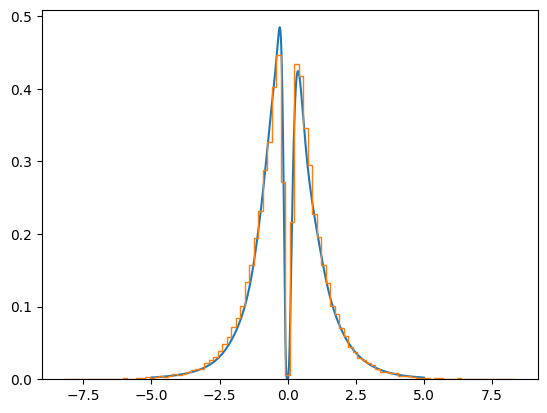

In [23]:
from matplotlib import pyplot as plt

# Plot network log likelihood
plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), np.exp(net_out));

# Plot simulation histogram
plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    fill=None,
    density=True,
);